In [3]:
%matplotlib widget
import os
import sys

sys.path.insert(0, os.getenv("HOME") + "/pycode/MscThesis/")
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det

from amftrack.notebooks.analysis.util import *
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update(
    {"font.family": "verdana", "font.weight": "normal", "font.size": 20}
)
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.util.sys import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
    load_graphs,
    load_skel,
)

C:\Users\coren\AppData\Local\Temp\ipykernel_18580\993479358.py:29: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [12]:
directory = directory_project
directory = r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\510_20220623\\'

update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [13]:
analysis_info

,folder_analysis,CrossDate,Pbait,Plate,PrincePos,Temperature,date,date_begin,date_end,date_run_analysis,...,path_global_hypha_info,path_global_plate_info,path_time_hypha_info,path_time_plate_info,root,split,strain,total_path,unique_id,version
0,Analysis_510_20220623_100_Version1,20220623,'-',510,11,25,"24.06.2022, 13:41:","24.06.2022, 13:41:","03.07.2022, 19:39:","01.01.1970, 01:00:",...,Analysis_510_20220623_100_Version1/global_hyph...,Analysis_510_20220623_100_Version1/global_plat...,Analysis_510_20220623_100_Version1/time_hypha_...,Analysis_510_20220623_100_Version1/time_plate_...,'None','Y','C2',/projects/0/einf914/data/20220624_1341_Plate11,510_20220623,Version1


In [14]:
path_exp = f'{directory}{analysis_info.iloc[0]["path_exp"]}'
exp = pickle.load(open(path_exp, "rb"))
exp.dates.sort()

In [16]:
exp.hyphaes

[Hyphae(0,266),
 Hyphae(13,16),
 Hyphae(64,32),
 Hyphae(80,86794),
 Hyphae(85,102),
 Hyphae(188,118),
 Hyphae(202,125),
 Hyphae(225,214),
 Hyphae(226,127078),
 Hyphae(233,257),
 Hyphae(260,110210),
 Hyphae(294,277),
 Hyphae(338,403),
 Hyphae(341,391),
 Hyphae(348,338),
 Hyphae(370,389),
 Hyphae(382,404),
 Hyphae(387,300),
 Hyphae(404,382),
 Hyphae(441,434),
 Hyphae(443,384),
 Hyphae(447,435),
 Hyphae(448,481),
 Hyphae(461,110314),
 Hyphae(484,460),
 Hyphae(491,505),
 Hyphae(504,641),
 Hyphae(511,496),
 Hyphae(542,623),
 Hyphae(624,636),
 Hyphae(643,655),
 Hyphae(655,643),
 Hyphae(663,715),
 Hyphae(673,110386),
 Hyphae(699,673),
 Hyphae(711,735),
 Hyphae(723,724),
 Hyphae(735,890),
 Hyphae(742,79742),
 Hyphae(744,756),
 Hyphae(780,824),
 Hyphae(825,907),
 Hyphae(832,897),
 Hyphae(837,864),
 Hyphae(887,836),
 Hyphae(888,891),
 Hyphae(890,735),
 Hyphae(904,868),
 Hyphae(906,905),
 Hyphae(907,825),
 Hyphae(950,959),
 Hyphae(951,960),
 Hyphae(959,950),
 Hyphae(960,951),
 Hyphae(969,984),
 H

In [23]:
select=[hypha for hypha in exp.hyphaes if len(hypha.ts)>30]

In [31]:
select

[Hyphae(742,79742),
 Hyphae(744,756),
 Hyphae(1150,127442),
 Hyphae(1327,119424),
 Hyphae(10616,92600),
 Hyphae(71251,71252),
 Hyphae(122761,136397),
 Hyphae(79725,79742),
 Hyphae(102350,105408),
 Hyphae(102772,109948),
 Hyphae(105408,102350),
 Hyphae(109318,107443),
 Hyphae(111741,115710),
 Hyphae(111828,143962),
 Hyphae(111831,111830),
 Hyphae(111859,111849),
 Hyphae(111860,128151),
 Hyphae(111861,111841),
 Hyphae(112039,103540),
 Hyphae(112040,126381),
 Hyphae(121468,130415),
 Hyphae(122388,128015),
 Hyphae(123319,120929),
 Hyphae(126849,111860)]

In [30]:
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    get_pixel_growth_and_new_children,
)
hyph = select[0]
t0 = hyph.ts[0]
tf = hyph.ts[-1]
[np.linalg.norm(hyph.end.pos(hyph.ts[0])-hyph.end.pos(hyph.ts[-1]))*1.725 for hyph in select]


[3627.819772432197,
 809.9568460726782,
 54.54928963790454,
 2462.2911274359903,
 32.40980754339649,
 21.61418804859438,
 155.33622605496763,
 5820.781119456821,
 3197.326006309804,
 229.80729427065629,
 266.34357510553923,
 941.1942085058747,
 290.0052844346116,
 105.28154218570319,
 125.05952582670383,
 175.14484898220672,
 135.88139359382507,
 7411.2699330563455,
 222.43806441344523,
 225.84328222242965,
 34.153257531310246,
 215.02386204791318,
 396.6487370772785,
 280.45974978595416]

In [32]:
def get_timedelta(hypha, t, tp1, args):
    exp = hypha.experiment
    seconds = (exp.dates[tp1] - exp.dates[t]).total_seconds()
    return ("timedelta", seconds / 3600)

In [36]:
hyph = select[-7]
t0 = hyph.ts[0]
tf = hyph.ts[-1]
for tf in hyph.ts[1:]:
    print(np.linalg.norm(hyph.end.pos(t0)-hyph.end.pos(tf))*1.725/get_timedelta(hyph, t0, tf, None)[1])

54.24029164520582
49.499873217647874
47.28871501464794
38.66600439112437
31.80163400743493
48.28480973932175
48.082154960419096
51.3387178398444
52.77616686578155
53.30570985480824
54.38617502849102
54.71973693259407
50.52444894859372
52.056867539245374
58.77315281817747
59.06053049934962
61.62077865902913
63.750420882128616
64.4521247229218
66.02995037664812
66.07024194233972
65.03679548871166
68.18214331596243
68.85135293678738
70.24002700511694
71.08700910345526
72.25456891148508
72.93053992338054
73.08225545982256
73.69110223684461
74.16852505524766
74.41634359497753
74.89149859786956
75.50612596413278
75.39284188983545
76.14811924191292
76.87307050594865
76.78918147567052
76.93589762023281
77.38705490844136
77.69762779962691
78.2162898610302
78.27386202307446
78.31492635650821
77.66814897165091
78.13580995098795
77.89425501369301
76.92603086747788
75.67668413604164


In [40]:
data = pd.read_json(r'C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\PRINCE\510_20220623\Analysis_510_20220623_100_Version1\time_plate_info.json').transpose()

In [51]:
data.columns

Index(['num_trunks', 'area', 'area_sep_comp', 'num_tips', 'num_nodes',
       'area_study', 'num_tips_study', 'num_nodes_study', 'tot_length_study',
       'out_study',
       ...
       'ring_active_tips_density_incr-100_index-10',
       'ring_active_tips_density_incr-100_index-11',
       'ring_active_tips_density_incr-100_index-12',
       'ring_active_tips_density_incr-100_index-13',
       'ring_active_tips_density_incr-100_index-14',
       'ring_active_tips_density_incr-100_index-15',
       'ring_active_tips_density_incr-100_index-16',
       'ring_active_tips_density_incr-100_index-17',
       'ring_active_tips_density_incr-100_index-18',
       'ring_active_tips_density_incr-100_index-19'],
      dtype='object', length=114)

<AxesSubplot:xlabel='date'>

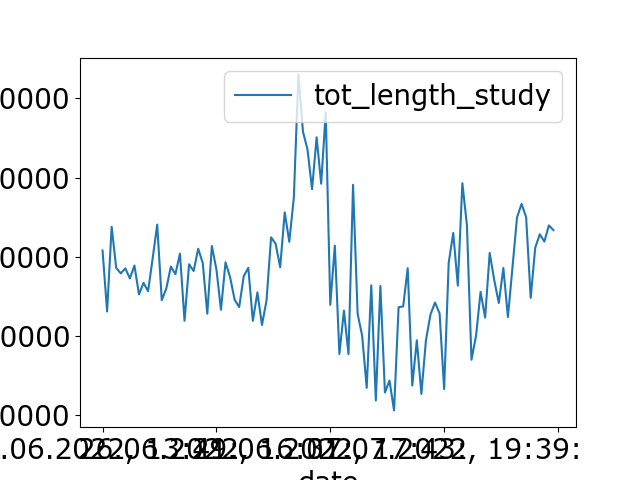

In [52]:
data.plot("date",'tot_length_study')

In [7]:
load_study_zone(exp)
load_graphs(exp, labeled=True, indexes=[t, tp1])
load_skel(exp, [t, tp1])

In [9]:
hyph.get_nodes_within(t)

([19015, 19019, 19033], [Edge(19015,19019), Edge(19019,19033)])

In [8]:
get_speed(hyph, t, tp1, None)
get_timestep(hyph, t, tp1, None)
get_degree(hyph, t, tp1, None)
get_width_tip_edge(hyph, t, tp1, None)
get_width_root_edge(hyph, t, tp1, None)
get_width_average(hyph, t, tp1, None)
get_timestep_init(hyph, t, tp1, None)
get_time_init(hyph, t, tp1, None)
has_reached_final_pos(hyph, t, tp1, None)
local_density(hyph, t, tp1, [1000])
local_density(hyph, t, tp1, [500])
local_density(hyph, t, tp1, [2000])
in_ROI(hyph, t, tp1, [2000])

('speed', 159.8542088647885)

('timestep', 38)

('degree', 1)

('width_tip_edge', 8.296408207778246)

('width_root_edge', 8.168785884492257)

('av_width', 8.266330707226807)

('timestep_init', 38)

('time_init', 163.18333333333334)

('has_reached_final_pos', False)

/home/cbisot/miniconda3/envs/amftrack/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


('density_window1000', 1273.623188405797)

('density_window500', 3383.1884057971015)

('density_window2000', 1826.0869565217392)

('in_ROI', True)